In [25]:
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from os.path import abspath
import numpy as np
import pandas as pd

from utils.generate_network import generate_network
from utils.prepare_data import prepare_data
from utils.popphy_io import get_config, save_params, load_params
from utils.popphy_io import get_stat, get_stat_dict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from models.PopPhy import PopPhyCNN
from models.CNN1D import CNN1D

import warnings
from datetime import datetime
import json
import warnings
warnings.filterwarnings("ignore")

Obtain data using PopPhy

In [16]:
config = get_config()
dataset = config.get('Evaluation', 'DataSet')
num_test = int(config.get('Evaluation', 'NumberTestSplits'))
path = "../data/" + dataset
my_maps, _, _, _, tree_features, labels, label_set, g, feature_df = prepare_data(path, config)
    
num_class = len(np.unique(labels))
if num_class == 2:
    metric = "AUC"
else:
    metric = "MCC"

seed = np.random.randint(100)
np.random.seed(seed)
np.random.shuffle(my_maps)
np.random.seed(seed)
np.random.shuffle(labels)

n_values = np.max(labels) + 1
    
print("There are %d classes...%s" % (num_class, ", ".join(label_set)))
print(my_maps.shape)

num_split = int(config.get('Evaluation', 'NumberTestSplits'))
skf = StratifiedKFold(n_splits=num_split, shuffle=True, random_state=seed)
train_index, test_index = next(iter(skf.split(my_maps, labels)))
train_x, test_x = my_maps[train_index,:,:], my_maps[test_index,:,:]
train_y, test_y = labels[train_index], labels[test_index]
train_x = np.log(train_x + 1)
test_x = np.log(test_x + 1)

num_train_samples = train_x.shape[0]
num_test_samples = test_x.shape[0]
tree_row = train_x.shape[1]
tree_col = train_x.shape[2]

scaler = MinMaxScaler().fit(train_x.reshape(-1, tree_row * tree_col))
train_x = np.clip(scaler.transform(train_x.reshape(-1, tree_row * tree_col)), 0, 1).reshape(-1, tree_row, tree_col)
test_x = np.clip(scaler.transform(test_x.reshape(-1, tree_row * tree_col)), 0, 1).reshape(-1, tree_row, tree_col)

train = [train_x, train_y]
test = [test_x, test_y]

There are 52 raw features...
Building tree structure...
Found tree file...
Populating trees...
There are 98 tree features...
There are 2 classes...1, 0
(72, 10, 42)


Run SimCLR

In [3]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

2023-05-16 16:33:52.765437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# # Dataset hyperparameters
# labeled_dataset_size = config.getint('SimCLR', 'labeled_dataset_size')
image_width = config.getint('SimCLR', 'image_width')
image_height = config.getint('SimCLR', 'image_height')
image_channels = config.getint('SimCLR', 'image_channels')

# Algorithm hyperparameters
num_epochs = config.getint('SimCLR', 'num_epochs')
width = config.getint('SimCLR', 'num_epochs')
temperature = config.getfloat('SimCLR', 'temperature')

In [5]:
train

[array([[[0.79157642, 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.79157642, 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.45175709, 0.50020395, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.7113129 , 0.72909711, 0.78084339, ..., 0.        ,
          0.52821307, 0.73495431],
         [0.        , 0.65551769, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.69147204, 0.68261487, 0.        , ..., 0.        ,
          0.        , 0.        ]],
 
        [[1.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [1.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.72617488, 0.30682035, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.68172924, 0.69650597, 0.81194907, ..., 0.        ,
          0.33717169, 0.

In [6]:
from ContrastivePopPhy import ContrastiveModel

# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(train[0], train[1], epochs=num_epochs, validation_data=test)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 10, 42, 1)        0         
 se)                                                             
                                                                 
 conv_0 (Conv2D)             (None, 8, 38, 32)         512       
                                                                 
 conv_1 (Conv2D)             (None, 6, 34, 32)         15392     
                                                                 
 flatten (Flatten)           (None, 6528)              0         
                                                                 
 fc_0 (Dense)                (None, 32)                208928    
                                                                 
Total params: 224,832
Trainable params: 224,832
Non-trainable params: 0
________________________________________________

In [8]:
from image_augment import get_augmenter

config = get_config()
contrastive_augmentation = {
    "brightness": config.getfloat('SimCLR', 'brightness_contrastive'), 
    "jitter": config.getfloat('SimCLR', 'jitter_contrastive')
    }
classification_augmentation = {
    "brightness": config.getfloat('SimCLR', 'brightness_classification'), 
    "jitter": config.getfloat('SimCLR', 'jitter_classification')
    }

# Supervised finetuning of the pretrained encoder
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(image_height, image_width, image_channels)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(10),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    train[0], train[1], epochs=num_epochs, validation_data=test
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

Epoch 1/50
2/2 [==============================] - 2s 468ms/step - loss: 2.3002 - acc: 0.4833 - val_loss: 2.0355 - val_acc: 0.5000
Epoch 2/50
2/2 [==============================] - 0s 124ms/step - loss: 1.9373 - acc: 0.6167 - val_loss: 1.5405 - val_acc: 0.5833
Epoch 3/50
2/2 [==============================] - 0s 92ms/step - loss: 1.4178 - acc: 0.6833 - val_loss: 0.9991 - val_acc: 0.6667
Epoch 4/50
2/2 [==============================] - 0s 110ms/step - loss: 0.9181 - acc: 0.7000 - val_loss: 0.7373 - val_acc: 0.6667
Epoch 5/50
2/2 [==============================] - 0s 76ms/step - loss: 0.6769 - acc: 0.8000 - val_loss: 0.6640 - val_acc: 0.7500
Epoch 6/50
2/2 [==============================] - 0s 74ms/step - loss: 0.6088 - acc: 0.8167 - val_loss: 0.7313 - val_acc: 0.5833
Epoch 7/50
2/2 [==============================] - 0s 65ms/step - loss: 0.5971 - acc: 0.7667 - val_loss: 0.6338 - val_acc: 0.6667
Epoch 8/50
2/2 [==============================] - 0s 61ms/step - loss: 0.6578 - acc: 0.6667 - 

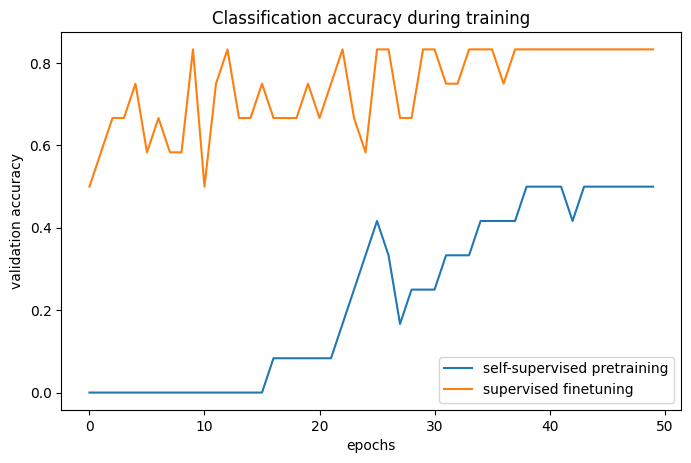

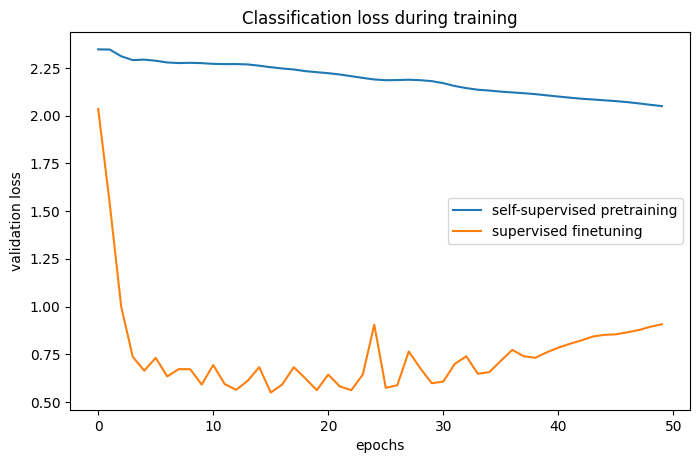

In [10]:
def plot_training_curves(pretraining_history, finetuning_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history)

In [17]:
import pandas as pd

pretrain_hist_df = pd.DataFrame(pretraining_history.history)
with open('result/pretraining_history.csv', mode='w') as f:
    pretrain_hist_df.to_csv(f)

finetune_hist_df = pd.DataFrame(finetuning_history.history)
with open('result/finetune_history.csv', mode='w') as f:
    finetune_hist_df.to_csv(f)


In [18]:
finetuning_model.save('result/finetuning_model')

INFO:tensorflow:Assets written to: result/finetuning_model/assets


INFO:tensorflow:Assets written to: result/finetuning_model/assets


In [7]:
finetuning_model = keras.models.load_model('result/finetuning_model')

2023-05-16 16:36:58.989470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'images' with dtype float and shape [?,10,42,1]
	 [[{{node images}}]]
2023-05-16 16:36:58.994751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,10,42,1]
	 [[{{node Placeholder}}]]
2023-05-16 16:36:59.035261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,10,42,1]
	 [[{{node 

In [15]:
finetuning_model.summary()
print(finetuning_model.layers[1].output)

Model: "finetuning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 10, 42, 1)         0         
                                                                 
 sequential_2 (Sequential)   (None, 32)                224832    
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 225,162
Trainable params: 225,162
Non-trainable params: 0
_________________________________________________________________
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='fc_0/Relu:0', description="created by layer 'fc_0'")


ordered data (as original)

In [34]:
my_maps, _, _, _, tree_features, labels, label_set, g, feature_df = prepare_data(path, config)
x = my_maps
y = labels
x = np.log(x + 1)

tree_row = x.shape[1]
tree_col = x.shape[2]

scaler = MinMaxScaler().fit(x.reshape(-1, tree_row * tree_col))
x = np.clip(scaler.transform(x.reshape(-1, tree_row * tree_col)), 0, 1).reshape(-1, tree_row, tree_col)

features = finetuning_model.layers[1].predict(x)
print(features)
print(y)
np.savetxt("result/features_out.csv", features, delimiter=",")
np.savetxt("result/labels_out.csv", y, delimiter=",", fmt='%s')

There are 52 raw features...
Building tree structure...
Found tree file...
Populating trees...
There are 98 tree features...
3/3 [==============================] - 0s 50ms/step
[[ 0.         9.642004   2.74985   ...  0.        12.165408   1.1585608]
 [ 0.         8.864508   2.666422  ...  0.        13.315447   3.2298048]
 [ 0.         9.248458   3.0299292 ...  0.        14.392896   2.7076411]
 ...
 [ 0.         7.798358   1.8018993 ...  0.        15.81324    4.0652456]
 [ 0.         8.408148   2.1184986 ...  0.        15.8512745  3.4621897]
 [ 0.         8.343044   1.9373866 ...  0.        15.017538   3.575128 ]]
[0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1]
